PyNILM - Exploratory Data Analysis
---



## Preparing Environment

In [29]:
# # COLAB VERSION
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [1]:
import warnings
warnings.filterwarnings(action="ignore")

# TODO: Create PyNilm python package
import sys
sys.path.append('../') # enabling pynilm import (src content)

import numpy as np

from tqdm import tqdm
from pathlib import Path
from nilmtk.utils import print_dict
from collections import Counter
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import io as pio
pio.renderers.default = 'vscode'

## Experiment Details - REDD

### Defining Experiment Configuration

In [2]:
# Dataset file
redd_filepath = '../data/redd.h5'
redd_filepath

'../data/redd.h5'

In [3]:
# experiment params
sample_period = 2
building_redd = 3
appliances_redd = ['washer dryer', 'microwave', 'dish washer', 'fridge']

### Loading Data - `Data Wrapper`

In [4]:
from src.data import DataWrapper

# Load data series between date start and finish
redd_train = DataWrapper(
    dataset_path=redd_filepath,
    building=building_redd, 
    appliances=appliances_redd,
    sample_period=sample_period,
    # start='2011-04-01 00:00:00',
    # end='2011-04-29 23:59:59',
    return_mode='dataframe',
    windows_size=None,
    windows_stride=None,
    get_activations=True,
    activations_type=int,
    debug=False
    )

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=16, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=7, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


### Aggregated Power Consumption (Mains)

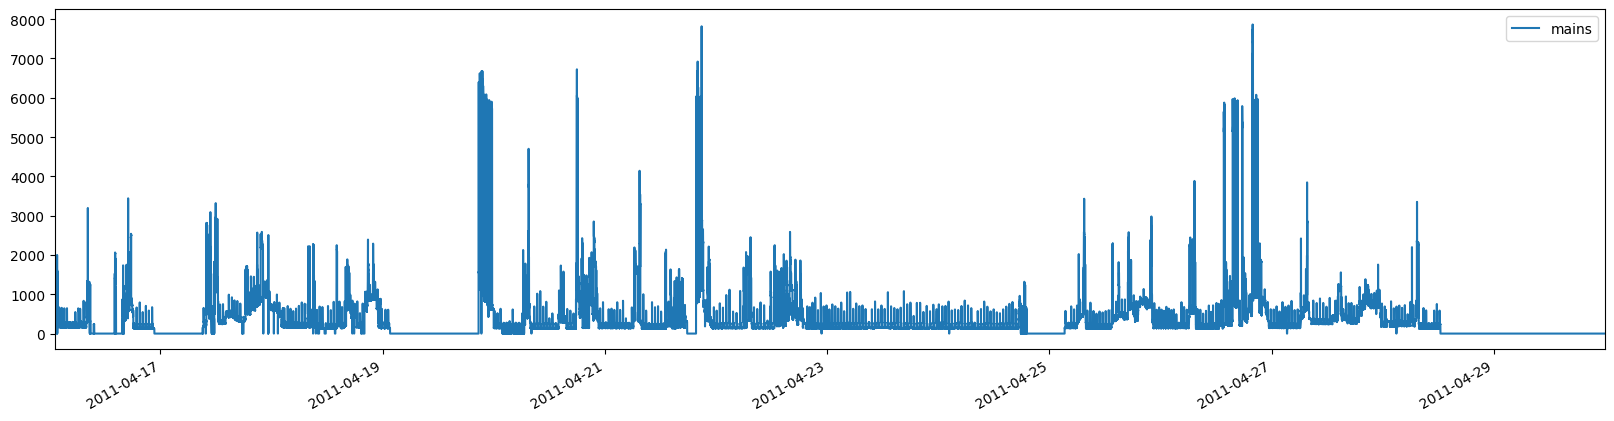

In [47]:
redd_train.data[['mains']].plot(figsize=(20, 5));

### Appliances Power Consumption

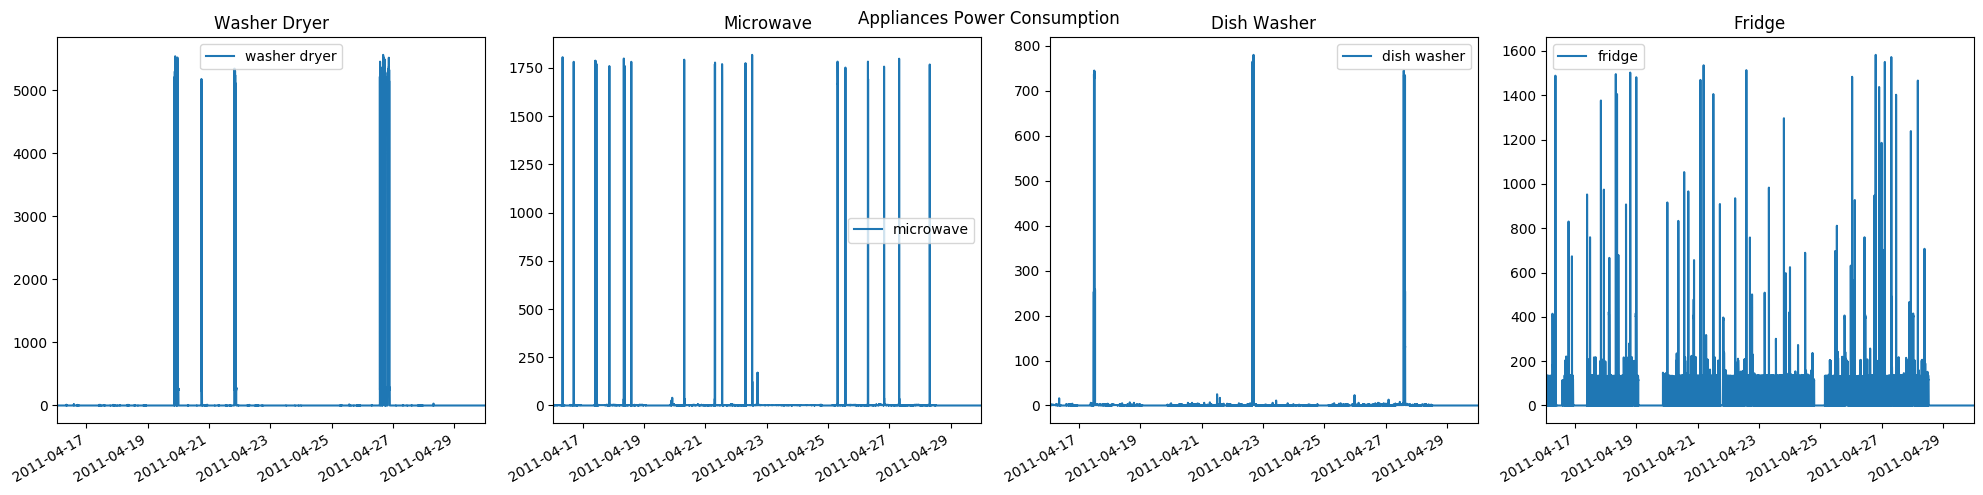

In [36]:
fig, axes = plt.subplots(1, len(appliances_redd), figsize=(20,5))

for a, ax in zip(appliances_redd, axes):
    redd_train.data[[a]].plot(ax=ax)
    ax.set_title(a.title())

plt.suptitle("Appliances Power Consumption")
plt.tight_layout()
plt.show()

### Power Consumption Overview 

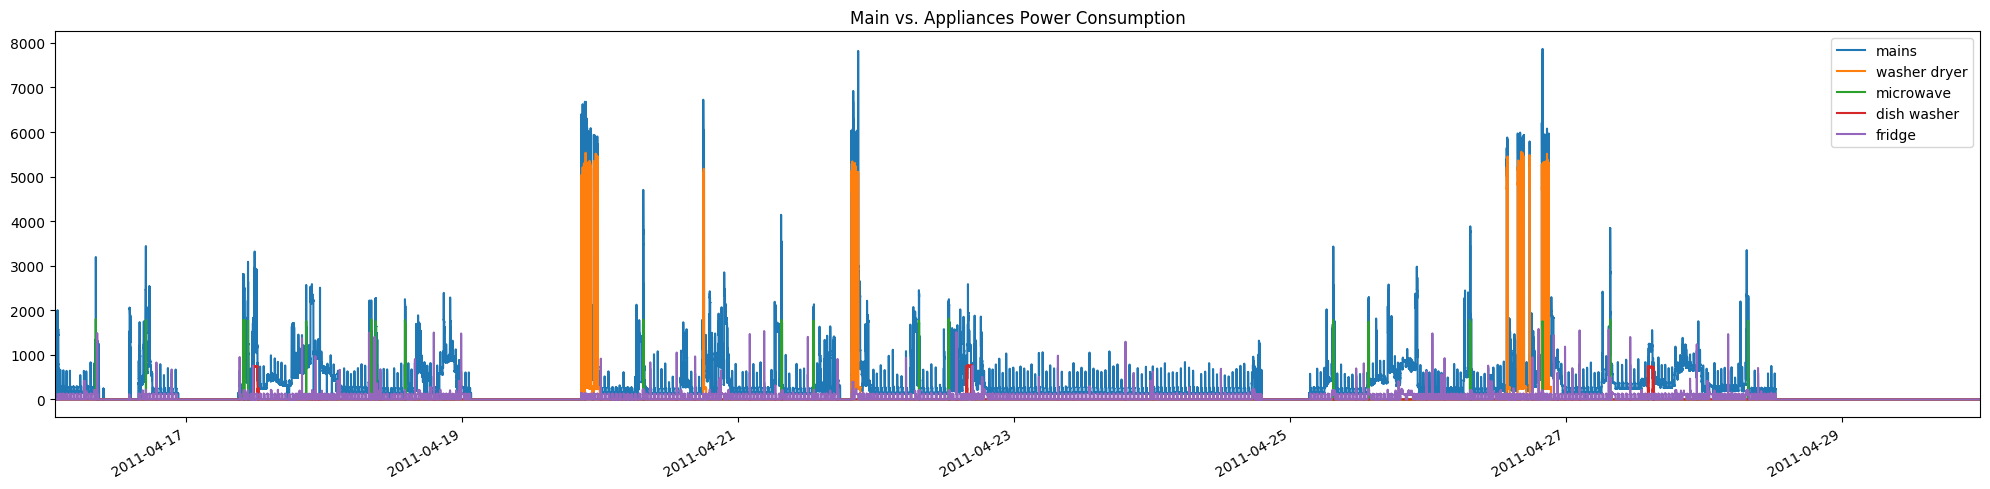

In [10]:
redd_train.data.plot(figsize=[20, 5])

plt.title("Main vs. Appliances Power Consumption")
plt.tight_layout()
plt.show()

In [ ]:
fig = px.line(
    redd_train.data, 
    title=f"""Building #{building_redd} Power Consumption of {redd_train.dataset.metadata['name']} database<br><sup>From `{redd_train.start}` To `{redd_train.end}` (sample period = {sample_period})</sup>""",
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title="Power",
    legend_title="Legend",
)

fig.show(renderer='vscode')

### Windowing Time Series

#### Global Dataframe

In [38]:
# Generating windows from a single dataframe, containing ALL appliance data
redd_train = DataWrapper(
    dataset_path=redd_filepath,
    building=building_redd, 
    appliances=appliances_redd,
    sample_period=sample_period,
    start='2011-04-01 00:00:00',
    end='2011-04-29 23:59:59',
    return_mode='dataframe', 
    windows_size=1000, # --------------> HERE!!!
    windows_stride=1000, # --------------> HERE!!!
    get_activations=True,
    activations_type=int,
    debug=False
    )

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=16, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=7, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


Activation distribution by appliance:

washer dryer = {0: 577, 1: 25}
microwave = {0: 580, 1: 22}
dish washer = {0: 594, 1: 8}
fridge = {1: 450, 0: 152}

------------------------------------------------

Mains/Appliance Activations examples:


Washer Dryer:


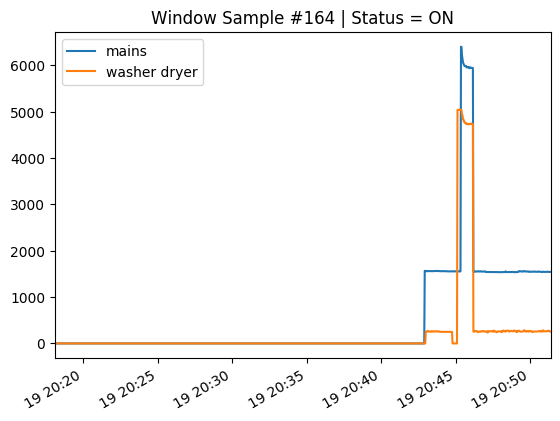

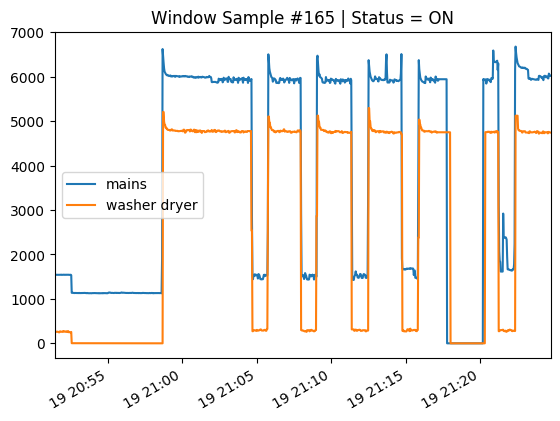

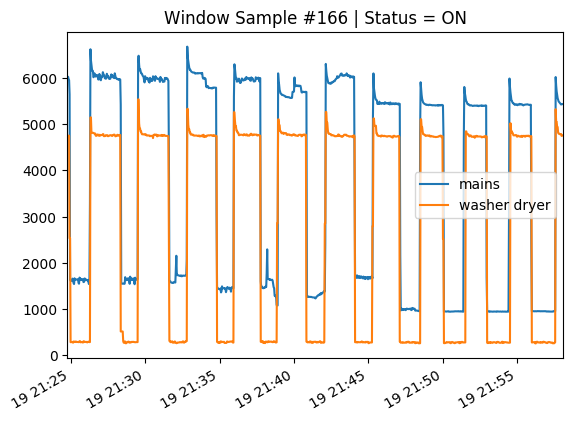

Microwave:


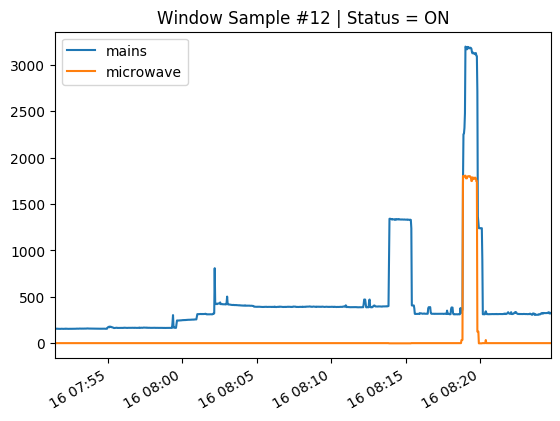

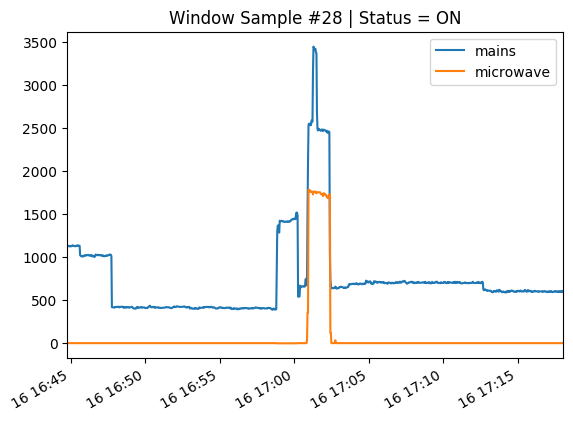

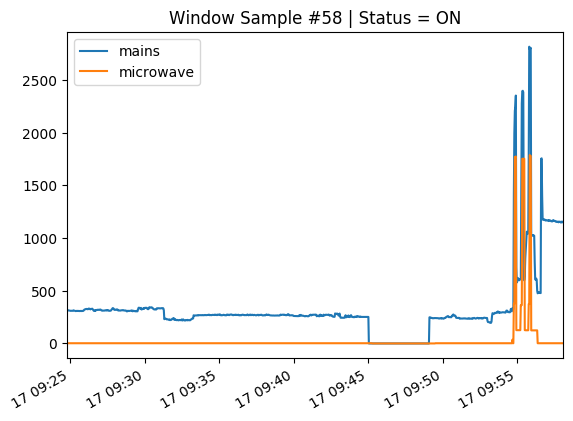

Dish Washer:


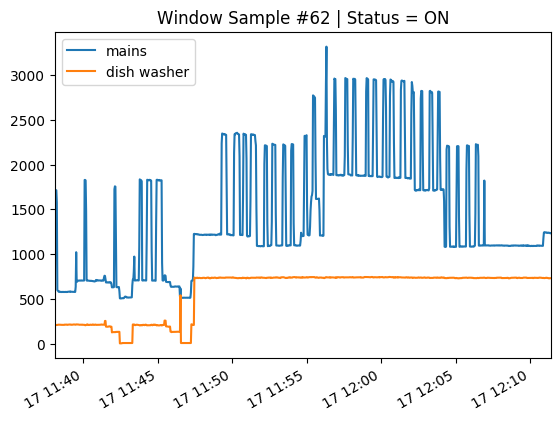

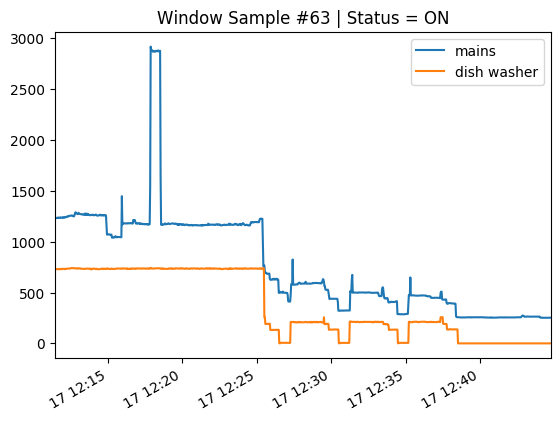

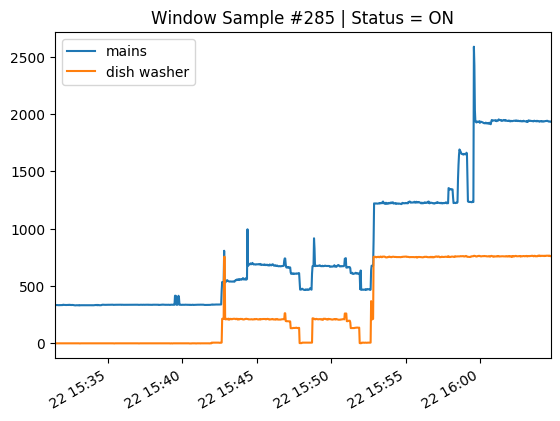

Fridge:


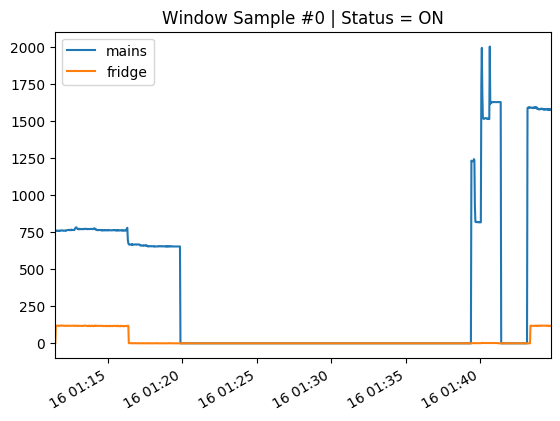

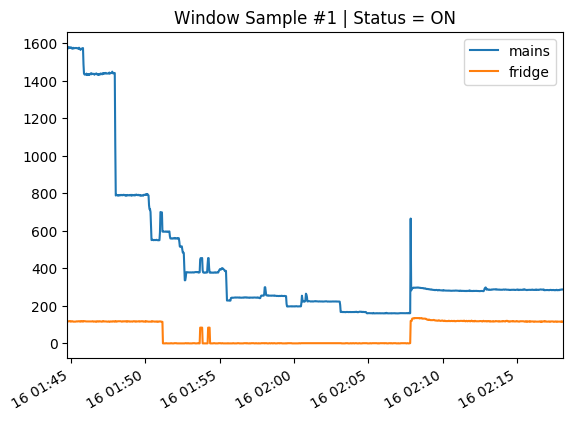

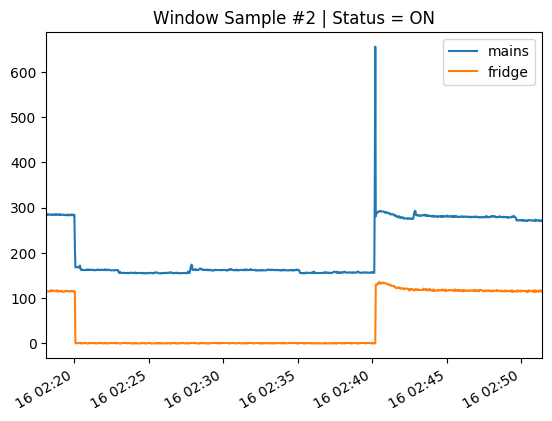

In [39]:
print('Activation distribution by appliance:\n')
for a, s in redd_train.activations.items():
    print(a, '=', dict(Counter(s)))
print('\n------------------------------------------------\n')

# Generating status
print('Mains/Appliance Activations examples:\n\n')
for a in appliances_redd:
    print(f'{a.title()}:')
    
    samples = 0
    for i in range(len(redd_train.data)):
        df = redd_train.data[i][[redd_train.mains_label, a]]
        status = redd_train.activations[a][i]
        
        if status and samples < 3:
            df.plot()
            plt.title(f'Window Sample #{i} | Status = {"ON" if status else "OFF"}')
            plt.show()
            samples += 1

In [40]:
import os
import imageio

# Saving GIF based on windows
filenames = []
for i, window in enumerate(redd_train.data[:1000]):
    window.plot()
    plt.title(f'window {i+1}')
    # gif
    filename = f'images/window_{i+1}.png'
    filenames.append(filename)
    # gif - save frame
    plt.savefig(filename)
    plt.close()
    
# gif - build it
with imageio.get_writer(
    f'images/sample{redd_train.sample_period}_windows{redd_train.windows_size}_stride{redd_train.windows_stride}.gif', 
    mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
# gif - Remove files
for filename in set(filenames):
    os.remove(filename)

#### Individual Dataframes (dict)

In [41]:
# Generating windows from individual appliance dataframes, 
#  containing mains and appliance power consumptions information
redd_train = DataWrapper(
    dataset_path=redd_filepath,
    building=building_redd, 
    appliances=appliances_redd,
    sample_period=sample_period,
    start='2011-04-01 00:00:00',
    end='2011-04-29 23:59:59',
    return_mode='dict', # --------------> HERE!!!
    windows_size=1000, # --------------> HERE!!!
    windows_stride=1000, # --------------> HERE!!!
    get_activations=False,
    activations_type=int,
    debug=False
    )

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=16, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=7, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


In [42]:
print('Windows by Appliance:\n')
for k, v in redd_train.data.items():
    print(k, '=>', len(v), 'window samples')

Windows by Appliance:

washer dryer => 602 window samples
microwave => 602 window samples
dish washer => 602 window samples
fridge => 602 window samples


## Additional Research

### Optimizing RP parameters - `Time Delay` and `Embedding Dimension`

In [43]:
from src.timeseries import RecurrencePlot

# RP parameters
time_delay = 1
embedding_dimension = 2

# Sample data
redd_train = DataWrapper(
    dataset_path=redd_filepath,
    building=building_redd, 
    appliances=appliances_redd,
    sample_period=sample_period,
    start='2011-04-01 00:00:00',
    end='2011-04-29 23:59:59',
    return_mode='dataframe',
    windows_size=None,
    windows_stride=None,
    get_activations=True,
    activations_type=int,
    debug=False
    )

Loading data for meter ElecMeterID(instance=2, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=14, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=16, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=9, building=3, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=7, building=3, dataset='REDD')     
Done loading data all meters for this chunk.


In [44]:
# Recurrence Plot Wrapper
rp_mains = RecurrencePlot(
    data=redd_train.data['mains'].values
    )

##### `Time Delay` - Mutual Information Method

local_min: [0]


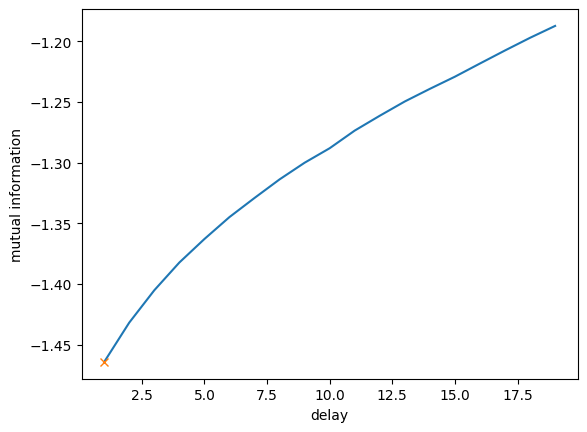

Delay = 1


(1, -1.4317507533873461)

In [45]:
delay, mutual_information = rp_mains.calculate_mutual_information(delay_range=20, debug=True)
delay, mutual_information

##### `Threshold` - False Nearest Neighbor Method

In [ ]:
embedding_dimension, false_neighbors = rp_mains.calculate_embedding_dimension(max_dimensions=15, debug=True)
embedding_dimension, false_neighbors